#Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy 
nltk.download('stopwords')
nltk.download("book")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Package chat80 is already up-to-date!
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package conll2000 to /root/nltk_data...
[nltk_data]    |   Package conll2000 is already up-to-date!
[nltk_data]    | Downloading package conll2002 to /root/nltk_data...
[nltk_data]    |   Package conll2002 is already up-to-date!
[nltk_data]    | Downloading package dependency_treebank to
[nltk_data]    | 

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/tanim913/glass-type-classification/main/covid19_tweets.csv")


In [ ]:
df.shape

(179108, 13)

In [ ]:
df = df.head(30000)

In [ ]:
df.shape

(30000, 13)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         30000 non-null  object
 1   user_location     23876 non-null  object
 2   user_description  28349 non-null  object
 3   user_created      30000 non-null  object
 4   user_followers    30000 non-null  int64 
 5   user_friends      30000 non-null  int64 
 6   user_favourites   30000 non-null  int64 
 7   user_verified     30000 non-null  bool  
 8   date              30000 non-null  object
 9   text              30000 non-null  object
 10  hashtags          21487 non-null  object
 11  source            29997 non-null  object
 12  is_retweet        30000 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 2.6+ MB


# Covid 19 Tweet Sentiment Analysis

## Process Datasets

In [ ]:
# Drop Columns
drop_columns = [
    'user_name',
    'user_description',
    'user_created',
    'user_followers',
    'user_friends',
    'user_favourites',
    'user_verified',
    'hashtags',
    'source',
    'is_retweet'
]

df.drop(columns=drop_columns, inplace=True)
df.head()

,user_location,date,text
0,astroworld,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...
1,"New York, NY",2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2,"Pewee Valley, KY",2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...
3,Stuck in the Middle,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...
4,Jammu and Kashmir,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...


## Basic Tweet Processing
* Make lower case
* Remove Mentions
* Remove URLs
* Remove Stopwords (Common words without much meaning)
* Remove punctuations 

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

from textblob import TextBlob
from textblob import Word


stop_words = set(stopwords.words('english'))

def tweet_scrubber(tweet):
   
    # Make tweets all lower case
    tweet = tweet.lower()
#     # Remove Mentions
    tweet = re.sub(r'@[A-Za-z0-9_]+','',tweet)
#     # Remove URLs
#     tweet = re.sub(r"http\S+", "", tweet)
#     # Remove Numbers
#     tweet = re.sub(r"[0-9]*", "", tweet)
#     # Remove Special Characters, and Punctuations
#     tweet = re.sub(r"(”|“|-|\+|`|#|,|;|\|)*", "", tweet)
#     tweet = re.sub(r"&amp", "", tweet)
    
    to_remove = r'\d+|http?\S+|[^A-Za-z0-9]+'
    tweet = re.sub(to_remove, " ", tweet)
    return tweet
        

def tokenization_and_stem(tweet, stem=False, lemmatize=False):
        
    filtered_tweet = []
    words = word_tokenize(tweet) 

    # Remove stopwords and stem
    for word in words:
        if not word in stop_words:
            if lemmatize:
                filtered_tweet.append(Word(word).lemmatize())
            else:
                filtered_tweet.append(word)
            
    return filtered_tweet

In [ ]:
df.text = df.text.apply(lambda x: tokenization_and_stem(tweet_scrubber(x), lemmatize=True))

In [ ]:
df.text.head()

0    [smelled, scent, hand, sanitizers, today, some...
1             [hey, made, sense, player, pay, respect]
2    [trump, never, claimed, covid, hoax, claim, ef...
3    [one, gift, covid, give, appreciation, simple,...
4    [july, medium, bulletin, novel, coronavirusupd...
Name: text, dtype: object

## Sentiment Analysis

In [ ]:
def sentiment_analysis(df):
    
    # Determine polarity and subjectivity
    df['Polarity'] = df['text'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)
    df['Subjectivity'] = df['text'].apply(lambda x: TextBlob(' '.join(x)).sentiment.subjectivity)
    
    # Classify overall sentiment
    df.loc[df.Polarity > 0,'Sentiment'] = 'positive'
    df.loc[df.Polarity == 0,'Sentiment'] = 'neutral'
    df.loc[df.Polarity < 0,'Sentiment'] = 'negative'
    
    return df[['text','Polarity','Subjectivity','Sentiment']].head()

In [ ]:
sentiment_analysis(df)

,text,Polarity,Subjectivity,Sentiment
0,"[smelled, scent, hand, sanitizers, today, some...",-0.25,0.250000,negative
1,"[hey, made, sense, player, pay, respect]",0.00,0.000000,neutral
2,"[trump, never, claimed, covid, hoax, claim, ef...",0.00,0.000000,neutral
3,"[one, gift, covid, give, appreciation, simple,...",0.00,0.357143,neutral
4,"[july, medium, bulletin, novel, coronavirusupd...",0.00,0.000000,neutral


In [ ]:
df['Sentiment'].value_counts()

neutral     12690
positive    12159
negative     5151
Name: Sentiment, dtype: int64

In [ ]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: None if x== 'neutral' else x)

dataset = df[["text","Sentiment"]]
dataset.dropna(inplace = True)
dataset.shape
dataset

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,text,Sentiment
0,"[smelled, scent, hand, sanitizers, today, some...",negative
5,"[coronavirus, covid, death, continue, rise, al...",negative
6,"[covid, change, work, general, recruiting, spe...",positive
8,"[praying, good, health, recovery, covid, covid...",positive
12,"[one, safe, covid, everyone, safe, commit, ens...",positive
...,...,...
29989,"[ill, barely, swallow, anymore, zero, sleep, t...",negative
29992,"[indiafightscorona, minding, mind, covid, stig...",positive
29994,"[live, free, die, trying, fuck, unmasked, jers...",positive
29998,"[may, failure, act, promptly, let, make, habit...",negative


In [ ]:
dataset['Sentiment'].value_counts()

positive    12159
negative     5151
Name: Sentiment, dtype: int64

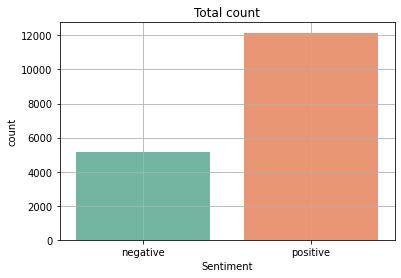

In [ ]:
sns.countplot(x='Sentiment',data=dataset, palette='Set2')
plt.title('Total count')
plt.grid()

In [ ]:
def change_sen(sentiment):
    if sentiment == "positive":
        return 1
    elif sentiment == "negative":
        return 0

In [ ]:
dataset['Sentiment'] = dataset['Sentiment'].apply(lambda x : change_sen(x))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dataset

,text,Sentiment
0,"[smelled, scent, hand, sanitizers, today, some...",0
5,"[coronavirus, covid, death, continue, rise, al...",0
6,"[covid, change, work, general, recruiting, spe...",1
8,"[praying, good, health, recovery, covid, covid...",1
12,"[one, safe, covid, everyone, safe, commit, ens...",1
...,...,...
29989,"[ill, barely, swallow, anymore, zero, sleep, t...",0
29992,"[indiafightscorona, minding, mind, covid, stig...",1
29994,"[live, free, die, trying, fuck, unmasked, jers...",1
29998,"[may, failure, act, promptly, let, make, habit...",0


In [ ]:
X = dataset['text']
y = dataset['Sentiment']

In [ ]:
temp = dataset

In [ ]:
sentences=[]

for words,classes in  zip(X,y):
    sentence = ' '.join(words)
    sentences.append([sentence,classes])
    


In [ ]:
df=pd.DataFrame(sentences,columns=['text','sentiment'])
df      

,text,sentiment
0,smelled scent hand sanitizers today someone pa...,0
1,coronavirus covid death continue rise almost b...,0
2,covid change work general recruiting specifica...,1
3,praying good health recovery covid covidpositive,1
4,one safe covid everyone safe commit ensure,1
...,...,...
17305,ill barely swallow anymore zero sleep throat s...,0
17306,indiafightscorona minding mind covid stigmatis...,1
17307,live free die trying fuck unmasked jerseystron...,1
17308,may failure act promptly let make habit wear m...,0


In [ ]:
from google.colab import drive
from google.colab import files
from google.colab import  drive
drive.mount('/content/drive')
#df.to_csv('preprocessed_data_covid_tweets.csv', index=False)
proData = pd.read_csv("/content/preprocessed_data_covid_tweets.csv")
proData

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,text,sentiment
0,smelled scent hand sanitizers today someone pa...,0
1,coronavirus covid death continue rise almost b...,0
2,covid change work general recruiting specifica...,1
3,praying good health recovery covid covidpositive,1
4,one safe covid everyone safe commit ensure,1
...,...,...
17305,ill barely swallow anymore zero sleep throat s...,0
17306,indiafightscorona minding mind covid stigmatis...,1
17307,live free die trying fuck unmasked jerseystron...,1
17308,may failure act promptly let make habit wear m...,0


In [ ]:
X = df['text']
y = df['sentiment']


# Bag of Words

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1, shuffle=True)

In [ ]:
#CountVectorizer is used to represent the words as a list of values, instead of text
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

vectorizer.fit(X)
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)


In [ ]:
X_train = X_train.toarray()
X_test = X_test.toarray()
X_val = X_val.toarray()

In [ ]:
dummy = pd.DataFrame(X_train)
dummy

,0,1,2,3,4,5,6,7,8,9,...,19555,19556,19557,19558,19559,19560,19561,19562,19563,19564
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11074,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11075,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
num_of_features = X_test.shape[1]
print('Total number of features: ', num_of_features)

Total number of features:  19565


In [ ]:
print('Total training data: ', X_train.shape[0])
print('Total validation data:  ', X_val.shape[0])
print('Total testing data:  ', X_test.shape[0])

Total training data:  11078
Total validation data:   2770
Total testing data:   3462


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
#import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(Dense(units=256, activation='relu', input_dim=len(vectorizer.get_feature_names_out())))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_m, precision_m, recall_m])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F-1 Score:", f1_score)

Epoch 1/10
347/347 [==============================] - 10s 16ms/step - loss: 0.3251 - accuracy: 0.8619 - f1_m: 0.9030 - precision_m: 0.8831 - recall_m: 0.9300 - val_loss: 0.2288 - val_accuracy: 0.9126 - val_f1_m: 0.9391 - val_precision_m: 0.9131 - val_recall_m: 0.9691
Epoch 2/10
347/347 [==============================] - 3s 10ms/step - loss: 0.0688 - accuracy: 0.9780 - f1_m: 0.9841 - precision_m: 0.9820 - recall_m: 0.9869 - val_loss: 0.3208 - val_accuracy: 0.9105 - val_f1_m: 0.9363 - val_precision_m: 0.9182 - val_recall_m: 0.9577
Epoch 3/10
347/347 [==============================] - 4s 11ms/step - loss: 0.0152 - accuracy: 0.9963 - f1_m: 0.9974 - precision_m: 0.9977 - recall_m: 0.9972 - val_loss: 0.5548 - val_accuracy: 0.9043 - val_f1_m: 0.9335 - val_precision_m: 0.9025 - val_recall_m: 0.9692
Epoch 4/10
347/347 [==============================] - 3s 10ms/step - loss: 0.0101 - accuracy: 0.9970 - f1_m: 0.9979 - precision_m: 0.9980 - recall_m: 0.9979 - val_loss: 0.6562 - val_accuracy: 0.9058

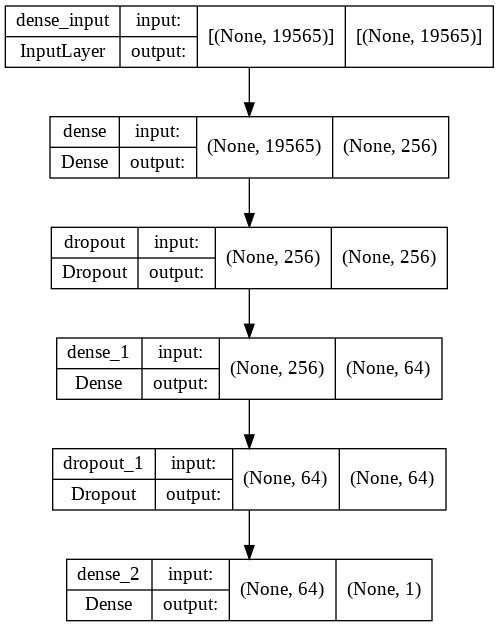

In [ ]:
keras.utils.plot_model(model, show_shapes = True, show_layer_names = True)

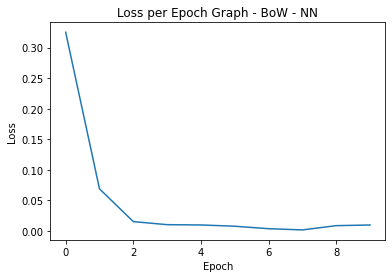

In [ ]:
import matplotlib.pyplot as plt

plt.title('Loss per Epoch Graph - BoW - NN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='loss')

plt.show()

# TF-IDF (Term Frequency - Inverse Document Frequency)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1, shuffle=True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

vectorizer.fit(X)
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

In [ ]:
X_train = X_train.toarray()
X_test = X_test.toarray()
X_val = X_val.toarray()

In [ ]:
dummy = pd.DataFrame(X_train)
dummy

,0,1,2,3,4,5,6,7,8,9,...,19555,19556,19557,19558,19559,19560,19561,19562,19563,19564
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
model = Sequential()
model.add(Dense(units=256, activation='relu', input_dim=len(vectorizer.get_feature_names_out())))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_m, precision_m, recall_m])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F-1 Score:", f1_score)

Epoch 1/10
347/347 [==============================] - 5s 11ms/step - loss: 0.3283 - accuracy: 0.8566 - f1_m: 0.9009 - precision_m: 0.8772 - recall_m: 0.9340 - val_loss: 0.2570 - val_accuracy: 0.9007 - val_f1_m: 0.9315 - val_precision_m: 0.8981 - val_recall_m: 0.9706
Epoch 2/10
347/347 [==============================] - 3s 10ms/step - loss: 0.0618 - accuracy: 0.9785 - f1_m: 0.9845 - precision_m: 0.9842 - recall_m: 0.9854 - val_loss: 0.3220 - val_accuracy: 0.9018 - val_f1_m: 0.9304 - val_precision_m: 0.9169 - val_recall_m: 0.9470
Epoch 3/10
347/347 [==============================] - 3s 9ms/step - loss: 0.0145 - accuracy: 0.9958 - f1_m: 0.9970 - precision_m: 0.9968 - recall_m: 0.9973 - val_loss: 0.3809 - val_accuracy: 0.9036 - val_f1_m: 0.9323 - val_precision_m: 0.9142 - val_recall_m: 0.9540
Epoch 4/10
347/347 [==============================] - 5s 13ms/step - loss: 0.0090 - accuracy: 0.9974 - f1_m: 0.9981 - precision_m: 0.9982 - recall_m: 0.9982 - val_loss: 0.4500 - val_accuracy: 0.8986 -

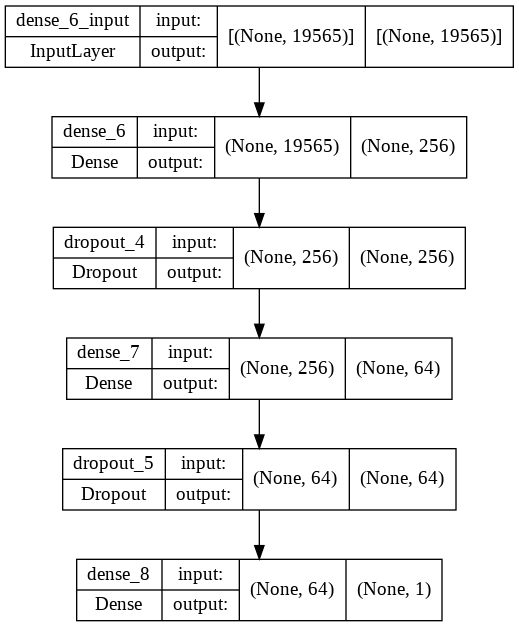

In [ ]:
keras.utils.plot_model(model, show_shapes = True, show_layer_names = True)

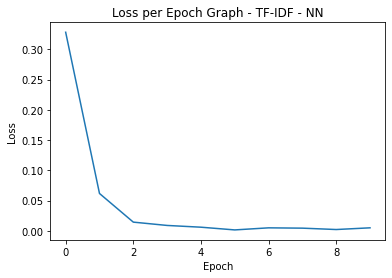

In [ ]:
import matplotlib.pyplot as plt

plt.title('Loss per Epoch Graph - TF-IDF - NN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='loss')

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1, shuffle=True)



#MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(alpha = 0.3, max_iter=1000,hidden_layer_sizes = (100, 90, 80, 70,60,50,40,30,20)) 
classifier
classifier.fit(X_train, y_train)
 
df_results = pd.DataFrame(data=np.zeros(shape=(1,3)), columns = ['classifier', 'train_score', 'test_score'] )
train_score = classifier.score(X_train, y_train)
test_score = classifier.score(X_test, y_test)
 
print  (classifier.predict_proba(X_test))
print  (classifier.predict(X_test))
 
df_results.loc[1,'classifier'] = "MLP"
df_results.loc[1,'train_score'] = train_score
df_results.loc[1,'test_score'] = test_score
print(df_results)

[[9.97845267e-01 2.15473347e-03]
 [4.41026845e-04 9.99558973e-01]
 [3.21196794e-05 9.99967880e-01]
 ...
 [4.36930698e-01 5.63069302e-01]
 [9.98209166e-01 1.79083416e-03]
 [2.17329854e-05 9.99978267e-01]]
[0 1 1 ... 1 0 1]
  classifier  train_score  test_score
0        0.0     0.000000    0.000000
1        MLP     0.990793    0.921144


#MLP Classifier With Early Stopping

In [ ]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(alpha = 0.3, max_iter=1000,hidden_layer_sizes = (100, 90, 80, 70,60,50,40,30,20),early_stopping=True) 
classifier
classifier.fit(X_train, y_train)
 
df_results = pd.DataFrame(data=np.zeros(shape=(1,3)), columns = ['classifier', 'train_score', 'test_score'] )
train_score = classifier.score(X_train, y_train)
test_score = classifier.score(X_test, y_test)
 
print  (classifier.predict_proba(X_test))
print  (classifier.predict(X_test))
 
df_results.loc[1,'classifier'] = "MLP"
df_results.loc[1,'train_score'] = train_score
df_results.loc[1,'test_score'] = test_score
print(df_results)

[[9.99621314e-01 3.78685852e-04]
 [1.09322446e-04 9.99890678e-01]
 [4.35498716e-05 9.99956450e-01]
 ...
 [3.75829991e-01 6.24170009e-01]
 [9.99692645e-01 3.07354944e-04]
 [2.36759991e-05 9.99976324e-01]]
[0 1 1 ... 1 0 1]
  classifier  train_score  test_score
0        0.0     0.000000     0.00000
1        MLP     0.994223     0.93472
